### Install Packages and Import Dataset

In this notebook, we’ll be working with a data set of real estate transactions in Sacramento, California. This dataset contains several features regarding property details, including location, size, type, and price..

Each row in the dataset represents a listing, with various property details:

- **City:** The city where the property is located.
- **Zip:** The postal code for the property’s location.
- **Beds:** The number of bedrooms in the property.
- **Baths:** The number of bathrooms in the property.
- **Sqft:** The square footage of the property.
- **Type:** The type of property (e.g., Residential).
- **Latitude:** The latitude coordinate of the property.
- **Longitude:** The longitude coordinate of the property.

The target column is **Price**, which we will try to predict based on the other features in the dataset.

This dataset was obtained from [spatialkey](https://support.spatialkey.com/spatialkey-sample-csv-data/)

#  Project: House Price Prediction Using KNN Regression

#  Objective:

To predict the price of a house based on its **square footage** using **K-Nearest Neighbors (KNN) Regression**.

 Dataset:

**Source:** `sacramento.csv` (house sales data)
**Main Features Used:**

  * `sq__ft`: size of the house
  * `price`: actual selling price




In [1]:


# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Show pipeline output as pandas DataFrames
set_config(transform_output="pandas")

# **Why?** Ensures pipeline transformations return clean DataFrames instead of NumPy arrays.

In [3]:

# Load dataset
sacramento = pd.read_csv("dataset/sacramento.csv")
sacramento.head()
#**Why?** Loads the dataset into memory and displays the first few rows for inspection.

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,1005 MORENO WAY,SACRAMENTO,95838,CA,3,2,1410,Residential,Fri May 16 00:00:00 EDT 2008,180000,38.646206,-121.442767
1,10105 MONTE VALLO CT,SACRAMENTO,95827,CA,4,2,1578,Residential,Fri May 16 00:00:00 EDT 2008,190000,38.573917,-121.316916
2,10133 NEBBIOLO CT,ELK GROVE,95624,CA,4,3,2096,Residential,Fri May 16 00:00:00 EDT 2008,289000,38.391085,-121.347231
3,10165 LOFTON WAY,ELK GROVE,95757,CA,3,2,1540,Residential,Fri May 16 00:00:00 EDT 2008,266510,38.387708,-121.436522
4,10254 JULIANA WAY,SACRAMENTO,95827,CA,4,2,2484,Residential,Fri May 16 00:00:00 EDT 2008,331200,38.568030,-121.309966


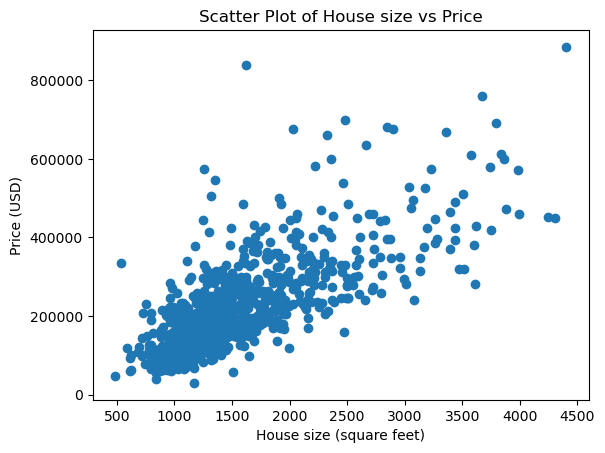

In [4]:
### 📊 Exploratory Data Analysis (EDA)

# Plot full data
plt.scatter(sacramento["sq__ft"], sacramento['price'])
plt.xlabel("House size (square feet)")
plt.ylabel("Price (USD)")
plt.title("Scatter Plot of House size vs Price")
plt.show()
# **Why?** Visualizes the relationship between house size and price. It's essential to understand if regression is suitable.


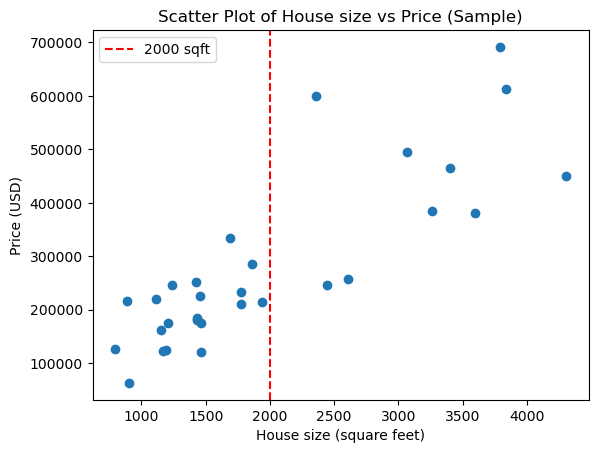

In [5]:
###🔍 Sampling for Simplicity
# Reproducible random sample
np.random.seed(10)
small_sacramento = sacramento.sample(n=30)

# **Why?** Reduces data size for demonstration or initial experimentation.

# Plot the small sample
plt.scatter(small_sacramento["sq__ft"], small_sacramento['price'])
plt.axvline(x=2000, color='red', linestyle='--', label='2000 sqft')
plt.xlabel("House size (square feet)")
plt.ylabel("Price (USD)")
plt.title("Scatter Plot of House size vs Price (Sample)")
plt.legend()
plt.show()

# **Why?** Helps us focus on a small dataset and visualize houses around a 2000 sqft size.


In [6]:
### Manual KNN Concept
# Manually finding closest 5 neighbors to 2000 sqft
small_sacramento["dist"] = (2000 - small_sacramento["sq__ft"]).abs()
nearest_neighbors = small_sacramento.nsmallest(5, "dist")
nearest_neighbors
# **Why?** Demonstrates the basic idea of KNN: choosing data points most similar to the target input.

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,dist
280,3228 I ST,SACRAMENTO,95816,CA,4,3,1939,Residential,Mon May 19 00:00:00 EDT 2008,215000,38.573844,-121.462839,61
197,8986 HAFLINGER WAY,ELK GROVE,95757,CA,3,2,1857,Residential,Fri May 16 00:00:00 EDT 2008,285000,38.397923,-121.450219,143
408,9474 VILLAGE TREE DR,ELK GROVE,95758,CA,4,2,1776,Residential,Mon May 19 00:00:00 EDT 2008,210000,38.413947,-121.408276,224
599,5340 BIRK WAY,SACRAMENTO,95835,CA,3,2,1776,Residential,Tue May 20 00:00:00 EDT 2008,234000,38.672495,-121.515251,224
786,8025 PEERLESS AVE,ORANGEVALE,95662,CA,2,1,1690,Residential,Wed May 21 00:00:00 EDT 2008,334150,38.711470,-121.216214,310


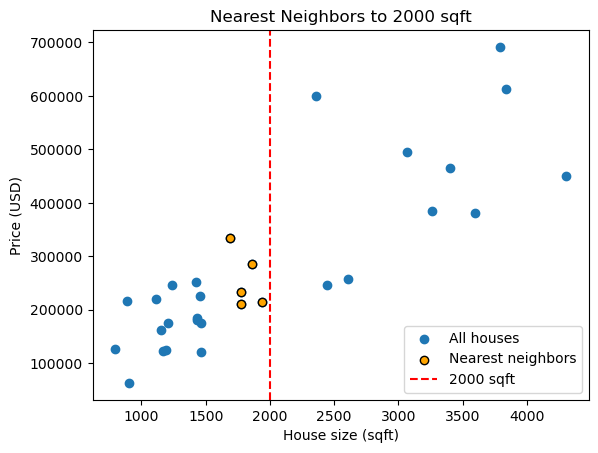

In [7]:

# Highlighting the nearest neighbors
plt.scatter(small_sacramento["sq__ft"], small_sacramento['price'], label='All houses')
plt.scatter(nearest_neighbors["sq__ft"], nearest_neighbors['price'], color='orange', label='Nearest neighbors', edgecolor='black')
plt.axvline(x=2000, color='red', linestyle='--', label='2000 sqft')
plt.xlabel("House size (sqft)")
plt.ylabel("Price (USD)")
plt.title("Nearest Neighbors to 2000 sqft")
plt.legend()
plt.show()
#**Why?** Visual confirmation of which points were chosen as "neighbors" by KNN.
# Why? Shows which neighbors are being used for the prediction.


In [8]:
# Predict price by averaging neighbors
prediction = nearest_neighbors["price"].mean()
print("Predicted price for 2000 sqft house:", prediction)


Predicted price for 2000 sqft house: 255630.0


 Part 2: KNN Model Training and Evaluation
Now we'll move from the manual concept to a full model pipeline.

In [9]:
# Step 1: Prepare Data for Modeling
# Drop rows with missing or zero square footage or price
sacramento_clean = sacramento[(sacramento["sq__ft"] > 0) & (sacramento["price"] > 0)]

# Define feature and target
X = sacramento_clean[["sq__ft"]]
y = sacramento_clean["price"]
#Why? Cleaning ensures we only train on valid data. X is the input (square footage), y is the output (price).

In [10]:
# Step 2: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
#✅ Why? Splitting ensures we can evaluate the model on unseen data (20% test set).

In [11]:
# Step 3: Build and Train the KNN Model
# Create a preprocessing + modeling pipeline
pipe = make_pipeline(
    StandardScaler(),  # scales input for better distance-based learning
    KNeighborsRegressor()
)

# Fit the pipeline on training data
pipe.fit(X_train, y_train)
#✅Why?
#StandardScaler is needed because KNN is distance-based, and unscaled data may mislead it.

#make_pipeline chains preprocessing and modeling steps cleanly.

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsregressor', KNeighborsRegressor())])

In [12]:
# Step 4: Evaluate the Model
# Predict on test data
y_pred = pipe.predict(X_test)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")
# Why? RMSE shows the average error in predictions (lower is better).

# R² explains how well the model captures variance in the data (closer to 1 is better).

RMSE: 87661.25
R² Score: 0.51


In [13]:
# Step 5: Tune the Hyperparameter k with GridSearchCV
# Grid search for best k
param_grid = {"kneighborsregressor__n_neighbors": range(1, 21)}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best k:", grid.best_params_["kneighborsregressor__n_neighbors"])
print("Best cross-validated score:", grid.best_score_)
#✅ Why? Tries different values for k and finds the one that gives the best performance.

Best k: 20
Best cross-validated score: 0.4849814561047047


In [14]:
#Step 6: Final Evaluation with Best Model

# Predict again using best model
y_pred_best = grid.predict(X_test)

# Final metrics
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print(f"Final RMSE: {rmse_best:.2f}")
print(f"Final R² Score: {r2_best:.2f}")
# ✅ Why? Confirms performance after tuning.

Final RMSE: 82313.57
Final R² Score: 0.57


✅ Summary of the Project

1. Data Cleaning - 	Remove invalid square footage or price
2. Manual KNN Concept	- Understand how neighbors influence prediction
3. Pipeline + Standardization	 - Ensures model isn't biased by input scale
4. Train/Test Split - 	Allows generalization to unseen data
5. Evaluation Metrics	- RMSE and R² to assess accuracy
6. GridSearchCV	 - Tunes k automatically for best results